In [1]:
from cscg_actions_PE import *
from ged import *
from util import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
import os
import pickle
import networkx as nx

In [2]:
# import numpy as np

def generate_custom_colors(num_unique_observations):
    # Define a fixed set of custom colors as RGB values
    predefined_colors = np.array([
        [214, 214, 214],
        [85, 35, 157],
        [253, 252, 144],
        [114, 245, 144],
        [151, 38, 20],
        [239, 142, 192],
        [214, 134, 48],
        [140, 194, 250],
        [72, 160, 162],
    ])

    # If the number of unique observations is greater than the number of predefined colors,
    # cycle through the predefined colors to ensure enough colors are available
    if num_unique_observations > len(predefined_colors):
        extra_colors_needed = num_unique_observations - len(predefined_colors)
        additional_colors = np.tile(predefined_colors, (extra_colors_needed // len(predefined_colors) + 1, 1))
        custom_colors = np.vstack((predefined_colors, additional_colors))[:num_unique_observations]
    else:
        custom_colors = predefined_colors[:num_unique_observations]

    return custom_colors


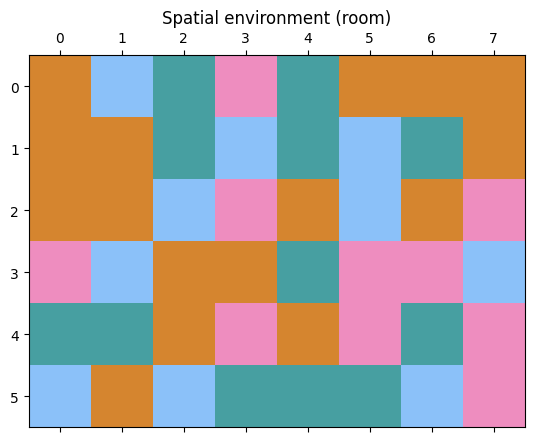

In [3]:
# room = np.array(
#     [
#         [1, 2, 3, 0, 3,],
#         [1, 1, 3, 2, 3,],
#         [1, 1, 2, 0, 1,],
#         [0, 2, 1, 1, 3,],
#         [3, 3, 1, 0, 1,],
#         [2, 1, 2, 3, 3,],
#     ]
# )

# Uncomment this for generating data from a bigger room. Will take longer to train.

room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Spatial environment (room)')
plt.savefig("figures/rectangular_room_layout.pdf")

In [5]:
import numpy as np

rows = 6
cols = 8
total_nodes = rows * cols
adjacency_matrix = np.zeros((total_nodes, total_nodes), dtype=int)

# Helper function to convert 2D grid coordinates to 1D index
def node_index(row, col):
    return row * cols + col

# Fill the adjacency matrix
for row in range(rows):
    for col in range(cols):
        index = node_index(row, col)

        # Self-connection for boundary nodes
        if row == 0 or row == rows - 1 or col == 0 or col == cols - 1:
            adjacency_matrix[index, index] = 1

        # Check for connection to the right
        if col + 1 < cols:
            right_index = node_index(row, col + 1)
            adjacency_matrix[index, right_index] = 1
        
        # Check for connection to the left
        if col - 1 >= 0:
            left_index = node_index(row, col - 1)
            adjacency_matrix[index, left_index] = 1
        
        # Check for connection above
        if row - 1 >= 0:
            up_index = node_index(row - 1, col)
            adjacency_matrix[index, up_index] = 1
        
        # Check for connection below
        if row + 1 < rows:
            down_index = node_index(row + 1, col)
            adjacency_matrix[index, down_index] = 1

# Optionally print the matrix
print(adjacency_matrix)
gt_A = adjacency_matrix


[[1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 1 1]]


In [6]:
nclone=1
a,x,rc = datagen_structured_obs_room(room, length=50000)
alpha_results_nclones = []
alpha_results_totalclone = []
alpha_results_ged = []
alphas = np.arange(0.1, 1.1, 0.1)
# alphas=[1.0]

seeds = np.arange(0,10,1)
currmodel = 'spatial'
n_orig_clones = 70
# for alpha in alphas: 
seed_results_totalclone = []
seed_results_nclones = []
seed_results_ged = []
#     for seed in seeds: 
for seed in seeds: 
    filename = 'model_spatial_PE_seed_' + str(seed) + '.pkl'
    folderpath = 'models'
    fullpath = os.path.join(folderpath, filename)
    if not os.path.isfile(fullpath):
        continue
    if os.path.isfile(fullpath):
        try: 
            print(filename)
            with open(fullpath, 'rb') as file: 
                chmm = pickle.load(file)
        except (pickle.UnpicklingError, EOFError) as e: 
            print("failed")
    chmm.pseudocount = 2e-3

    temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png" # Temporary file for each clone
    A = return_A(chmm, x, a, output_file=temp_output_file, cmap=cmap)
    ged = graph_edit_distance_nx_norm(chmm, x, a, gt_A, output_file=temp_output_file, cmap=cmap)
    print(ged)
    # graph, v, g, A = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
    # print("Ground truth number of nodes: {}, number of nodes recovered {}".format(len(room.flatten()), len(v)))

    # # display the image inline
    # display(Image(filename=temp_output_file))

    n_clones  = 0 
    container = chmm.container
    table = []

    for roomid in range(len(container.groups_of_tables)):
        # print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
        n_clones += len(container.groups_of_tables[roomid])
        table.append(len(container.groups_of_tables[roomid]))
    print("Total clones used: {}".format(n_clones))
#     print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables)*n_orig_clones))

    seed_results_totalclone.append(n_clones)
    seed_results_nclones.append(table)
    seed_results_ged.append(ged)
# alpha_results_totalclone.append(seed_results_totalclone)
# alpha_results_nclones.append(seed_results_nclones)
# alpha_results_ged.append(seed_results_ged)
            
        

model_spatial_PE_seed_0.pkl
0.8140417457305503
Total clones used: 45
model_spatial_PE_seed_1.pkl
0.8646034816247582
Total clones used: 43
model_spatial_PE_seed_2.pkl
0.817283950617284
Total clones used: 35
model_spatial_PE_seed_3.pkl
0.8336980306345733
Total clones used: 38
model_spatial_PE_seed_4.pkl
0.8375451263537906
Total clones used: 49
model_spatial_PE_seed_5.pkl
0.8178294573643411
Total clones used: 45
model_spatial_PE_seed_6.pkl
0.8555008210180624
Total clones used: 55
model_spatial_PE_seed_7.pkl
0.8277511961722488
Total clones used: 34
model_spatial_PE_seed_8.pkl
0.8220140515222483
Total clones used: 35
model_spatial_PE_seed_9.pkl
0.8476190476190476
Total clones used: 51


In [7]:
np.save('ged_norm_spatial_PE.npy', seed_results_ged)

In [10]:
np.softmax(0.4)

AttributeError: module 'numpy' has no attribute 'softmax'

In [21]:
import numpy as np

def sigmoid(x,beta=1.0):
    return 1 / (1 + np.exp(-x*beta))

# Example usage:
x = np.array([1.0, 2.0, 3.0,10.0])
sigmoid_x = sigmoid(x,0.1)
print(sigmoid_x)  # Output: [0.73105858 0.88079708 0.95257413]


[0.52497919 0.549834   0.57444252 0.73105858]


In [25]:
1/(0.1*10)

1.0

In [8]:
nclone=1
a,x,rc = datagen_structured_obs_room(room, length=50000)
alpha_results_nclones = []
alpha_results_totalclone = []
alpha_results_ged = []
alphas = np.arange(0.1, 1.1, 0.1)
# alphas=[1.0]

seeds = np.arange(0,100,1)
currmodel = 'spatial'
n_orig_clones = 70
for alpha in alphas: 
    seed_results_totalclone = []
    seed_results_nclones = []
    seed_results_ged = []
    for seed in seeds: 
        filename = 'model_spatial_PE_seed_0.pkl'
        folderpath = 'models'
        fullpath = os.path.join(folderpath, filename)
        if os.path.isfile(fullpath):
            try: 
                print(filename)
                with open(fullpath, 'rb') as file: 
                    chmm = pickle.load(file)
            except (pickle.UnpicklingError, EOFError) as e: 
                print("failed")
        chmm.pseudocount = 2e-3

        temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png" # Temporary file for each clone
        # A = return_A(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        ged = graph_edit_distance_nx(chmm, x, a, gt_A, output_file=temp_output_file, cmap=cmap)
        print(ged)
        # graph, v, g, A = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # print("Ground truth number of nodes: {}, number of nodes recovered {}".format(len(room.flatten()), len(v)))
        
        # # display the image inline
        # display(Image(filename=temp_output_file))
        
        # n_clones = 0 
        # container = chmm.container
        # table = []
        
        # for roomid in range(len(container.groups_of_tables)):
        #     # print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
        #     n_clones += len(container.groups_of_tables[roomid])
        #     table.append(len(container.groups_of_tables[roomid]))
        # # print("Total clones used: {}".format(n_clones))
        # # print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables)*n_orig_clones))
        
    #     seed_results_totalclone.append(n_clones)
    #     seed_results_nclones.append(table)
        seed_results_ged.append(ged)
    # alpha_results_totalclone.append(seed_results_totalclone)
    # alpha_results_nclones.append(seed_results_nclones)
    alpha_results_ged.append(seed_results_ged)
            
        

model_spatial_PE_seed_0.pkl
1074.0
model_spatial_PE_seed_0.pkl
1074.0
model_spatial_PE_seed_0.pkl


KeyboardInterrupt: 

In [7]:
nclone=1
a,x,rc = datagen_structured_obs_room(room, length=50000)
alpha_results_nclones = []
alpha_results_totalclone = []
alpha_results_ged = []
alpha_results_len_message = []
alphas = np.arange(0.1, 1.1, 0.1)
# alphas=[1.0]

seeds = np.arange(0,100,1)
currmodel = 'spatial'
n_orig_clones = 70
for alpha in alphas: 
    seed_results_totalclone = []
    seed_results_nclones = []
    seed_results_ged = []
    for seed in seeds: 
        filename = 'model_' + currmodel + '_alpha_' + str(alpha) + '_seed_' + str(seed) + '.pkl'
        folderpath = 'models'
        fullpath = os.path.join(folderpath, filename)
        if os.path.isfile(fullpath):
            try: 
                print(filename)
                with open(fullpath, 'rb') as file: 
                    chmm = pickle.load(file)
            except (pickle.UnpicklingError, EOFError) as e: 
                print("failed")
        chmm.pseudocount = 2e-3

        temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png" # Temporary file for each clone
        # A = return_A(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        mess_fwd = chmm.decode(x, a)[-1]
        print(len(mess_fwd))
        # ged = graph_edit_distance_nx(chmm, x, a, gt_A, output_file=temp_output_file, cmap=cmap)
        # print(ged)
        # graph, v, g, A = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # print("Ground truth number of nodes: {}, number of nodes recovered {}".format(len(room.flatten()), len(v)))
        
        # # display the image inline
        # display(Image(filename=temp_output_file))
        
        # n_clones = 0 
        # container = chmm.container
        # table = []
        
        # for roomid in range(len(container.groups_of_tables)):
        #     # print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
        #     n_clones += len(container.groups_of_tables[roomid])
        #     table.append(len(container.groups_of_tables[roomid]))
        # # print("Total clones used: {}".format(n_clones))
        # # print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables)*n_orig_clones))
        
    #     seed_results_totalclone.append(n_clones)
    #     seed_results_nclones.append(table)
        seed_results_ged.append(ged)
    # alpha_results_totalclone.append(seed_results_totalclone)
    # alpha_results_nclones.append(seed_results_nclones)
    alpha_results_ged.append(seed_results_ged)
            
        

model_spatial_alpha_0.1_seed_0.pkl
49999
model_spatial_alpha_0.1_seed_1.pkl
49999
model_spatial_alpha_0.1_seed_2.pkl
49999
model_spatial_alpha_0.1_seed_3.pkl


KeyboardInterrupt: 

In [50]:
np.save('ged_spatial_PE.npy', seed_results_ged)

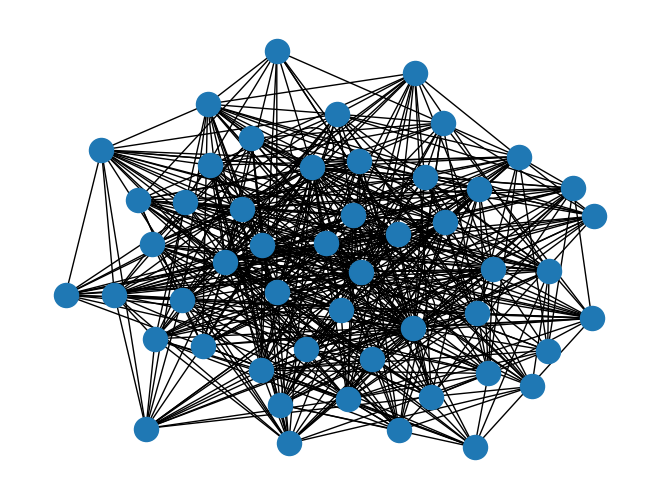

In [52]:
gt_G = nx.from_numpy_array(adjacency_matrix)
constructed_G = nx.from_numpy_array(A)
nx.draw(constructed_G)


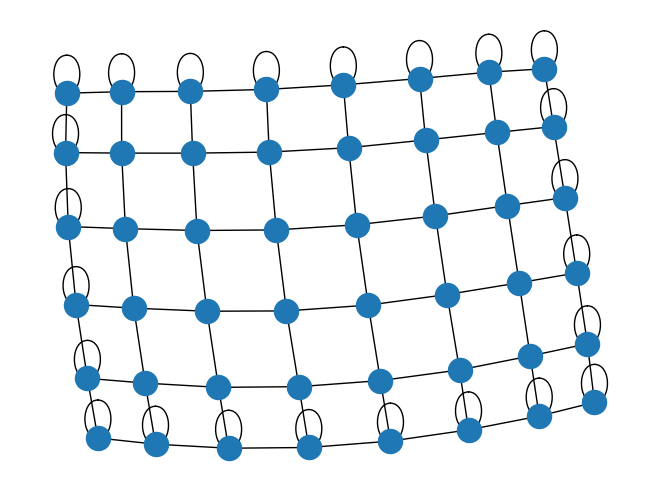

In [43]:
nx.draw(gt_G)

In [51]:
import pandas as pd
# Convert to a numpy array
data_array = np.array(seed_results_totalclone)

# Check original shape
print("Original shape:", data_array.shape)  # Should print (10, 100)

# Reshape to (100, 10)
reshaped_array = data_array.transpose()  # Transpose to change rows to columns and vice versa

# Check reshaped array's shape
print("Reshaped array shape:", reshaped_array.shape)  # Should print (100, 10)

# Convert to a pandas DataFrame
df = pd.DataFrame(reshaped_array)

# Export to CSV
csv_filename = 'spatial_results_PE.csv'
df.to_csv(csv_filename, index=False)  # index=False means do not write row indices


Original shape: (10,)
Reshaped array shape: (10,)


In [11]:
np.mean(alpha_results_totalclone,axis=1)

array([10.16, 15.37, 19.  , 25.91, 31.19, 36.27, 34.  , 45.45, 51.09,
       55.48])

In [12]:
np.std(alpha_results_totalclone,axis=1)

array([2.27912264, 3.30046966, 0.        , 4.78768211, 4.75330411,
       5.43112327, 0.        , 6.60511166, 7.33497785, 7.34640048])

In [21]:
import numpy as np
import igraph as ig
from queue import PriorityQueue

def create_igraph_from_adjacency(matrix):
    return ig.Graph.Adjacency((matrix > 0).tolist(), mode=ig.ADJ_DIRECTED)

def igraph_to_adj_list(graph):
    adj_list = {}
    for vertex in graph.vs:
        adj_list[vertex.index] = set(graph.neighbors(vertex, mode='out'))
    return adj_list

def heuristic(graph1, graph2):
    return abs(len(graph1) - len(graph2))

def graph_edit_distance(graphs, adj_list1, adj_list2):
    frontier = PriorityQueue()
    graph_id_counter = 0
    graphs[graph_id_counter] = adj_list1
    frontier.put((heuristic(adj_list1, adj_list2), 0, graph_id_counter))
    graph_id_counter += 1

    while not frontier.empty():
        estimated_cost, actual_cost, current_graph_id = frontier.get()
        current_graph = graphs[current_graph_id]

        if heuristic(current_graph, adj_list2) == 0:
            return actual_cost

        for vertex in set(current_graph).union(adj_list2):
            new_graph = dict(current_graph)
            if vertex in current_graph:
                new_graph.pop(vertex)
                for v in new_graph:
                    new_graph[v].discard(vertex)
            else:
                new_graph[vertex] = set()

            new_cost = actual_cost + 1
            graphs[graph_id_counter] = new_graph
            frontier.put((new_cost + heuristic(new_graph, adj_list2), new_cost, graph_id_counter))
            graph_id_counter += 1

    return float('inf')

def calculate_ged(matrix1, matrix2):
    graph1 = create_igraph_from_adjacency(matrix1)
    graph2 = create_igraph_from_adjacency(matrix2)
    adj_list1 = igraph_to_adj_list(graph1)
    adj_list2 = igraph_to_adj_list(graph2)
    graphs = {}
    return graph_edit_distance(graphs, adj_list1, adj_list2)

# Example matrices
# A = np.array([
#     [0, 1, 0],
#     [0, 0, 1],
#     [1, 0, 0]
# ])

B = np.array([
    [0, 1, 1],
    [1, 0, 0],
    [0, 0, 0]
])

# Calculate GED
ged_result = calculate_ged(A, B)
print(f"Graph Edit Distance: {ged_result}")


: 

: 

In [19]:
calculate_ged(A, B)

TypeError: '<' not supported between instances of 'dict' and 'dict'

In [18]:
A

array([[0.        , 0.0800843 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14892443, 0.23772752, ..., 0.01323773, 0.        ,
        0.        ],
       [0.        , 0.3703125 , 0.08489583, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.71428571, ..., 0.        , 0.        ,
        0.10084034],
       [0.        , 0.        , 0.33333333, ..., 0.        , 0.21376812,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.25770308]])

In [10]:
np.mean(alpha_results_totalclone,axis=1)

array([55.48])

In [11]:
np.std(alpha_results_totalclone,axis=1)

array([7.34640048])

In [5]:
np.mean(alpha_results_totalclone,axis=1)

array([10.16, 15.37, 19.  , 25.91, 31.19, 36.27, 34.  , 45.45, 51.09])

In [6]:
np.std(alpha_results_totalclone,axis=1)

array([2.27912264, 3.30046966, 0.        , 4.78768211, 4.75330411,
       5.43112327, 0.        , 6.60511166, 7.33497785])

## Comparing the graph edit distance with the ground-truth graph

In [4]:
# import numpy as np
import igraph as ig


def grid_to_directed_igraph(grid):
    """
    Convert a 2D numpy array to a directed igraph.Graph.
    Each cell has bidirectional connections to its horizontal and vertical neighbors.
    """
    rows, cols = grid.shape
    adjacency_matrix = np.zeros((rows * cols, rows * cols), dtype=int)

    index = lambda r, c: r * cols + c

    for r in range(rows):
        for c in range(cols):
            current_index = index(r, c)

            # North
            if r > 0:
                north_index = index(r - 1, c)
                adjacency_matrix[current_index, north_index] = 1
                adjacency_matrix[north_index, current_index] = 1

            # South
            if r < rows - 1:
                south_index = index(r + 1, c)
                adjacency_matrix[current_index, south_index] = 1
                adjacency_matrix[south_index, current_index] = 1

            # East
            if c < cols - 1:
                east_index = index(r, c + 1)
                adjacency_matrix[current_index, east_index] = 1
                adjacency_matrix[east_index, current_index] = 1

            # West
            if c > 0:
                west_index = index(r, c - 1)
                adjacency_matrix[current_index, west_index] = 1
                adjacency_matrix[west_index, current_index] = 1

    # Creating an igraph from the adjacency matrix
    graph = ig.Graph.Adjacency((adjacency_matrix > 0).tolist(), mode=ig.ADJ_DIRECTED)
    return graph

# Example room array
room = np.array([
    [1, 2, 3, 0, 3, 1, 1, 1],
    [1, 1, 3, 2, 3, 2, 3, 1],
    [1, 1, 2, 0, 1, 2, 1, 0],
    [0, 2, 1, 1, 3, 0, 0, 2],
    [3, 3, 1, 0, 1, 0, 3, 0],
    [2, 1, 2, 3, 3, 3, 2, 0],
])

directed_igraph = grid_to_directed_igraph(room)
print("Directed Graph Representation with igraph:")
print(directed_igraph)

Directed Graph Representation with igraph:
IGRAPH D--- 48 164 --
+ edges:
 0 ->  1  8         12 ->  4 11 13 20   24 -> 16 25 32      36 -> 28 35 37 44
 1 ->  0  2  9      13 ->  5 12 14 21   25 -> 17 24 26 33   37 -> 29 36 38 45
 2 ->  1  3 10      14 ->  6 13 15 22   26 -> 18 25 27 34   38 -> 30 37 39 46
 3 ->  2  4 11      15 ->  7 14 23      27 -> 19 26 28 35   39 -> 31 38 47
 4 ->  3  5 12      16 ->  8 17 24      28 -> 20 27 29 36   40 -> 32 41
 5 ->  4  6 13      17 ->  9 16 18 25   29 -> 21 28 30 37   41 -> 33 40 42
 6 ->  5  7 14      18 -> 10 17 19 26   30 -> 22 29 31 38   42 -> 34 41 43
 7 ->  6 15         19 -> 11 18 20 27   31 -> 23 30 39      43 -> 35 42 44
 8 ->  0  9 16      20 -> 12 19 21 28   32 -> 24 33 40      44 -> 36 43 45
 9 ->  1  8 10 17   21 -> 13 20 22 29   33 -> 25 32 34 41   45 -> 37 44 46
10 ->  2  9 11 18   22 -> 14 21 23 30   34 -> 26 33 35 42   46 -> 38 45 47
11 ->  3 10 12 19   23 -> 15 22 31      35 -> 27 34 36 43   47 -> 39 46


In [31]:
import igraph as ig
from queue import PriorityQueue

def heuristic(graph1, graph2):
    """
    Heuristic that considers both vertices and edges.
    """
    v_diff = abs(len(graph1.vs) - len(graph2.vs))
    e_diff = abs(len(graph1.es) - len(graph2.es))
    return v_diff + e_diff

def graph_edit_distance_igraph(graph1, graph2, max_iterations=10000):
    """
    Computes the approximate graph edit distance between two graphs
    using the A* algorithm with practical limitations.
    """
    frontier = PriorityQueue()
    graph_id = 0
    graphs = {graph_id: graph1}
    frontier.put((heuristic(graph1, graph2), 0, graph_id))
    graph_id += 1

    iterations = 0
    while not frontier.empty() and iterations < max_iterations:
        iterations += 1
        estimated_cost, actual_cost, current_graph_id = frontier.get()
        current_graph = graphs[current_graph_id]

        # Check if we reached the target structure
        if heuristic(current_graph, graph2) == 0:
            return actual_cost

        # Try adding and removing vertices and edges
        if len(current_graph.vs) < 20:  # Limit vertex count for demo purposes
            new_graph = current_graph.copy()
            new_graph.add_vertices(1)
            new_cost = actual_cost + 1
            graphs[graph_id] = new_graph
            frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
            graph_id += 1

        if len(current_graph.vs) > 1:
            for v in range(len(current_graph.vs)):
                new_graph = current_graph.copy()
                new_graph.delete_vertices(v)
                new_cost = actual_cost + 1
                graphs[graph_id] = new_graph
                frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
                graph_id += 1
                break  # Limit to one vertex modification per expansion for demo

        # Check if edges can be modified if graphs are similar in vertices but differ in edges
        if len(current_graph.vs) == len(graph2.vs):
            for e in current_graph.es:
                new_graph = current_graph.copy()
                new_graph.delete_edges(e.index)
                new_cost = actual_cost + 1
                graphs[graph_id] = new_graph
                frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
                graph_id += 1
                break  # Limit to one edge modification for demo

    return float('inf')  # Return infinity if no solution found within the constraints

# Example usage would involve defining specific igraph instances to test this function.

# # Example usage with igraph.Graph
# room_graph = ig.Graph.Adjacency((room > 0).tolist())
# target_graph = ig.Graph.Adjacency((np.random.randint(0, 2, room.shape) > 0).tolist())

# ged = graph_edit_distance_igraph(room_graph, target_graph)
# print(f"Graph Edit Distance: {ged}")


In [38]:
def spectral_similarity(graph1, graph2):
    L1 = np.array(graph1.laplacian())
    L2 = np.array(graph2.laplacian())
    eigenvalues1 = np.sort(np.linalg.eigvals(L1))
    eigenvalues2 = np.sort(np.linalg.eigvals(L2))

    # Pad the smaller array of eigenvalues to match the larger one
    max_len = max(len(eigenvalues1), len(eigenvalues2))
    eigenvalues1 = np.pad(eigenvalues1, (0, max_len - len(eigenvalues1)), 'constant')
    eigenvalues2 = np.pad(eigenvalues2, (0, max_len - len(eigenvalues2)), 'constant')

    # Calculate the Euclidean distance between the eigenvalue arrays
    distance = np.linalg.norm(eigenvalues1 - eigenvalues2)
    return distance

In [22]:
np.arange(0,100,10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [40]:
nclone=1
a,x,rc = datagen_structured_obs_room(room, length=50000)
# alpha_results_nclones = []
# alpha_results_totalclone = []
geds = []
alphas = np.arange(0.1, 1, 0.1)
seeds = np.arange(0,100,10) # modified to save time
currmodel = 'spatial'
n_orig_clones = 70
for alpha in alphas: 
    # seed_results_totalclone = []
    # seed_results_nclones = []
    seed_geds = []
    for seed in seeds: 
        filename = 'model_' + currmodel + '_alpha_' + str(alpha) + '_seed_' + str(seed) + '.pkl'
        folderpath = 'models'
        fullpath = os.path.join(folderpath, filename)
        if os.path.isfile(fullpath):
            try: 
                print(filename)
                with open(fullpath, 'rb') as file: 
                    chmm = pickle.load(file)
            except (pickle.UnpicklingError, EOFError) as e: 
                print("failed")
        chmm.pseudocount = 0.01

        temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png" # Temporary file for each clone
        # graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)

        graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # score = graph_edit_distance_igraph(g, directed_igraph)
        score = spectral_similarity(g,directed_igraph)
        seed_geds.append(score)
        print(score)
    geds.append(seed_geds)

model_spatial_alpha_0.1_seed_0.pkl
decode C: (4, 14, 14)
decode T: (4, 14, 14)
decode Pi: (4,)
decode n_clones: [6 4 3 1]
37.22372935708246
model_spatial_alpha_0.1_seed_10.pkl
decode C: (4, 9, 9)
decode T: (4, 9, 9)
decode Pi: (4,)
decode n_clones: [2 2 3 2]
31.55474045508928
model_spatial_alpha_0.1_seed_20.pkl
decode C: (4, 13, 13)
decode T: (4, 13, 13)
decode Pi: (4,)
decode n_clones: [2 4 3 4]
34.52754543037845
model_spatial_alpha_0.1_seed_30.pkl
decode C: (4, 10, 10)
decode T: (4, 10, 10)
decode Pi: (4,)
decode n_clones: [2 2 3 3]
34.490746699336164
model_spatial_alpha_0.1_seed_40.pkl
decode C: (4, 10, 10)
decode T: (4, 10, 10)
decode Pi: (4,)
decode n_clones: [1 2 5 2]
32.68821391306014
model_spatial_alpha_0.1_seed_50.pkl
decode C: (4, 8, 8)
decode T: (4, 8, 8)
decode Pi: (4,)
decode n_clones: [2 2 2 2]
31.007904956770762
model_spatial_alpha_0.1_seed_60.pkl
decode C: (4, 11, 11)
decode T: (4, 11, 11)
decode Pi: (4,)
decode n_clones: [2 6 2 1]
31.464731301515975
model_spatial_alpha

In [41]:
np.mean(geds,axis=0)


array([38.87402363, 40.89811239, 40.33908948, 40.65842353, 40.71010805,
       40.80950581, 41.81042349, 43.12211455, 40.92801616, 41.43108122])

In [42]:
np.std(geds,axis=0)

array([5.14637577, 3.68115964, 3.77352664, 3.77758989, 4.5162894 ,
       4.74330065, 4.19387617, 6.56863571, 2.67718338, 4.25676414])

In [39]:
spectral_similarity(g, directed_igraph)

34.490746699336164